# Selección de Atributos

In [11]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import sklearn.linear_model as lm

url = 'http://statweb.stanford.edu/~tibs/ElemStatLearn/datasets/prostate.data'
df = pd.read_csv(url, sep='\t', header=0)
df = df.drop('Unnamed: 0', axis=1)
istrain_str = df['train']
istrain = np.asarray([True if s == 'T' else False for s in istrain_str])
df = df.drop('train', axis=1)

scaler = StandardScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)
df_scaled['lpsa'] = df['lpsa']

X = df_scaled.ix[:,:-1]
N = X.shape[0]
X.insert(X.shape[1], 'intercept', np.ones(N))
y = df_scaled['lpsa']
Xtrain = X[istrain]
ytrain = y[istrain]
Xtest = X[np.logical_not(istrain)]
ytest = y[np.logical_not(istrain)]

Xm_train = Xtrain.as_matrix()
ym_train = ytrain.as_matrix()
Xm_test = Xtest.as_matrix()
ym_test = ytest.as_matrix()

In [49]:
from matplotlib import pyplot as plt
%matplotlib inline

def plot(training, test, desc=True):
    x_training, y_training = zip(*training)
    x_test, y_test = zip(*test)
    ax = plt.subplot(111)
    ax.plot(x_training, y_training, color="b", linestyle="-", marker='o', label='Training set')
    ax.plot(x_test, y_test, color="r", linestyle="-", marker='o', label='Test set')

    if desc:
        ax.set_xlim(max(x_training), min(x_training))

    ax.set_ylabel('MSE')
    ax.set_xlabel(u'Número de atributos')
    plt.legend(loc=1)

## a. Forward Step-wise Selection

Se utiliza el z-score como indicador para determinar la variable a agregar al modelo de regresión lineal.

In [45]:
def fss(x, y, names_x, test_data, k=10000):
    p = x.shape[1]
    k = min(p, k)
    names_x = np.array(names_x)
    remaining = range(0, p)
    selected = []
    points_training = []
    points_test = []
    while remaining and len(selected) <= k:
        score_candidates = []
        for candidate in remaining:
            model = lm.LinearRegression(fit_intercept=False)
            indexes = selected + [candidate]
            x_train = x[:, indexes]
            model.fit(x_train, y)  # fitting with training data

            # predicting training data
            predictions_train = model.predict(x_train)
            residuals_train = predictions_train - y

            # predicting test data
            x_test, y_test = test_data
            x_test = x_test[:, indexes]
            predictions_test = model.predict(x_test)
            residuals_test = predictions_test - y_test

            mse_candidate = np.mean(np.power(residuals_train, 2))
            mse_test = np.mean(np.power(residuals_test, 2))

            # Computing z scores
            var = (mse_candidate * x_train.shape[0]) / (x_train.shape[0] - x_train.shape[1] - 1)
            diag_values = np.diag(np.linalg.pinv(np.dot(x_train.T, x_train)))
            z_scores = np.divide(model.coef_, np.sqrt(np.multiply(var, diag_values)))

            # getting the z score that belongs to the last feature added
            z_score_candidate = z_scores[-1]

            # Using absolute value of the z score
            score_candidates.append((abs(z_score_candidate), mse_candidate, mse_test, candidate))

        score_candidates.sort()
        best_new_z_score, mse_candidate, mse_test, best_candidate = score_candidates.pop()
        remaining.remove(best_candidate)
        selected.append(best_candidate)
        points_training.append((len(selected), mse_candidate))
        points_test.append((len(selected), mse_test))
        print "selected= %s..." % names_x[best_candidate]
        print "totalvars=%d, best z_score = %f, mse = %f" % (len(indexes), best_new_z_score, mse_candidate)
    return selected, points_training, points_test

selected= intercept...
totalvars=1, best z_score = 16.493179, mse = 1.437036
selected= lcavol...
totalvars=2, best z_score = 8.624576, mse = 0.664606
selected= lweight...
totalvars=3, best z_score = 3.554040, mse = 0.553610
selected= svi...
totalvars=4, best z_score = 1.969567, mse = 0.521011
selected= lbph...
totalvars=5, best z_score = 1.972368, mse = 0.489776
selected= pgg45...
totalvars=6, best z_score = 1.181048, mse = 0.478648
selected= lcp...
totalvars=7, best z_score = 1.719063, mse = 0.455818
selected= age...
totalvars=8, best z_score = 1.473839, mse = 0.439363
selected= gleason...
totalvars=9, best z_score = 0.145411, mse = 0.439200


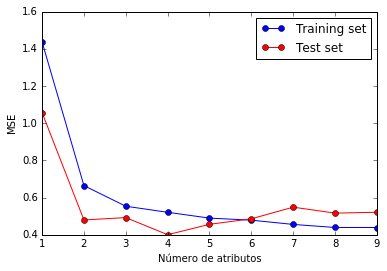

In [50]:
names_regressors = ["lcavol", "lweight", "age", "lbph", "svi", "lcp", "gleason", "pgg45", "intercept"]
selected, points_training, points_test = fss(Xm_train, ym_train, names_regressors, (Xm_test, ym_test))
plot(points_training, points_test, desc=False)

## b. Forward Step-wise Selection

Se utiliza el z-score como indicador para determinar la variable a quitar del modelo de regresión lineal.

In [59]:
def bss(x, y, names_x, test_data, k=10000):
    p = x.shape[1]
    k = min(p, k)
    names_x = np.array(names_x)
    selected = range(0, p)
    removed = []
    points_training = []
    points_test = []
    while len(selected) >= 1:
        model = lm.LinearRegression(fit_intercept=False)
        indexes = selected
        x_train = x[:, indexes]
        model.fit(x_train, y)  # fitting with training data

        # predicting training data
        predictions_train = model.predict(x_train)
        residuals_train = predictions_train - y

        # predicting test data
        x_test, y_test = test_data
        x_test = x_test[:, indexes]
        predictions_test = model.predict(x_test)
        residuals_test = predictions_test - y_test

        mse_train = np.mean(np.power(residuals_train, 2))
        mse_test = np.mean(np.power(residuals_test, 2))

        # Computing z scores
        var = (mse_train * x_train.shape[0]) / (x_train.shape[0] - x_train.shape[1] - 1)
        diag_values = np.diag(np.linalg.pinv(np.dot(x_train.T, x_train)))
        z_scores = np.divide(model.coef_, np.sqrt(np.multiply(var, diag_values)))
        score_candidates = zip(np.abs(z_scores), indexes)
        score_candidates.sort(reverse=True)

        # removing the worst
        worst_new_z_score, worst_candidate = score_candidates.pop()
        selected.remove(worst_candidate)
        removed.append(worst_candidate)

        points_training.append((len(indexes) + 1, mse_train))
        points_test.append((len(indexes) + 1, mse_test))
        print "selected= %s..." % names_x[worst_candidate]
        print "totalvars=%d, worst z_score = %f, mse = %f" % (len(indexes), worst_new_z_score, mse_train)
    return removed, points_training, points_test

selected= gleason...
totalvars=8, worst z_score = 0.145411, mse = 0.439200
selected= age...
totalvars=7, worst z_score = 1.473839, mse = 0.439363
selected= lcp...
totalvars=6, worst z_score = 1.719063, mse = 0.455818
selected= pgg45...
totalvars=5, worst z_score = 1.181048, mse = 0.478648
selected= lbph...
totalvars=4, worst z_score = 1.972368, mse = 0.489776
selected= svi...
totalvars=3, worst z_score = 1.969567, mse = 0.521011
selected= lweight...
totalvars=2, worst z_score = 3.554040, mse = 0.553610
selected= lcavol...
totalvars=1, worst z_score = 8.624576, mse = 0.664606
selected= intercept...
totalvars=0, worst z_score = 16.493179, mse = 1.437036


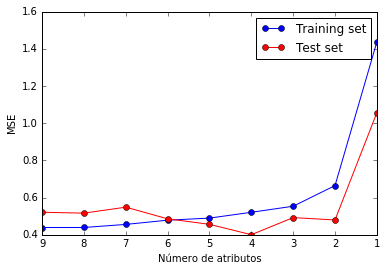

In [60]:
names_regressors = ["lcavol", "lweight", "age", "lbph", "svi", "lcp", "gleason", "pgg45", "intercept"]
removed, points_training, points_test = bss(Xm_train, ym_train, names_regressors, (Xm_test, ym_test))
plot(points_training, points_test)